# Network Generation Walkthrough

This notebook is a walkthrough of how to use NorthNet for network generation using reaction rules.

## Quick Installation Note

Since the code depends on some Python libraries, and NorthNet, please see the NorthNet installation instructions for how to create a virtual environment before running this notebook. You can make a virtual environment available in a Jupyter notebook using the following process:

1. Create the virtual environment (if not already created)
`conda create --name env-name`

2. Activate environment
`conda activate env-name`

3. Install ipykernel
`conda install -c anaconda ipykernel`

4. Run this line
`python -m ipykernel install --user --name=env-name`

5. Deactivate the environment
`conda deactivate`

It should then be possible to select the environment as a kernel from the Jupyter interface.

## Let's go!

First, let's get all of the imports loaded:

In [3]:
import yaml
from rdkit import Chem

from NorthNet import Classes
from NorthNet.Loading.reaction.reaction_list_parsing import load_reaction_templates_from_file
from NorthNet import network_generation as n_gen

## Loading Network Generation Settings

There are several settings to be defined in the network generation process. I've tried to put as many of these inputs in files which can be edited separately, so that the logic for network generation is separate from the actual code. There are two files to load in, one containing the reaction rules as tab-separated values and a yaml formatted configuration file defining the reaction rules to apply, starting compounds, etc.

When loading in the reaction SMARTS file, there may be an error such as:

```
'mapped atoms in the reactants were not mapped in the products.
unmapped numbers are: 5'
the error is attributable to the Cannizzaro reaction SMARTS, in which
O:5 is not mapped to the products
```

The code should still run.

The network generation parameters are in `params.yaml`. You can open the file and look at how it works. I hope it is self-explanatory. If you need more information on the .yaml format, search for 'yaml tutorial' or something similar to find an explanation that works for you.

In [4]:
with open('params.yaml', 'r') as file:
    text = file.read()

info = yaml.load(text, Loader = yaml.FullLoader)

reaction_SMARTS_file = info["reaction-smarts-file"]

reactions = load_reaction_templates_from_file(reaction_SMARTS_file)

network_name = info["network-name"]
description = info["network-description"]

iterations = info["iterations"]
start_smiles = info["initiator-smiles"]

## Setting up the Network

The following cell creates the Network object to be used in the network generation process and defined a 'reactivity pattern' which contains reaction rules which will be repeatedly applied to the network to expand its reactions and products.

In [5]:
initiator_species = [Classes.Compound(x) for x in start_smiles]
reaction_network = Classes.Network([], network_name, description)

reaction_network.add_compounds(initiator_species)

reaction_pattern = info["reaction-rules"]
deprotonation_rules = [x for x in reaction_pattern if "deprotonation" in x]
protonation_rules = [x for x in reaction_pattern if "protonation" in x]

## Setting up the generation process

Just before the network generation step, let's create a function which will help with generating epimers.

In [6]:
def generate_epimers(network, deprotonation_rules=[], protonation_rules=[]):
    """
    A function to generate all of the epimers of a sugar: over-iterates
    multiple times through a series of protonation/deprotonation reactions.

    Parameters
    ----------
    network: NorthNet.Network

    deprotonation_rules: list[NorthNet.ReactionTemplate]

    protonation_rules: list[NorthNet.ReactionTemplate]

    Returns
    -------
    None
    """

    hydroxide = Classes.Compound("[OH-]")
    water = Classes.Compound("O")

    i = 0
    reaction_number = len(network.NetworkReactions)
    while i < 0:
        for d_rule in deprotonation_rules:
            n_gen.extend_network_specific(network, [hydroxide], d_rule)

        for p_rule in protonation_rules:
            n_gen.extend_network_specific(network, [water], p_rule)

        new_reaction_number = len(network.NetworkReactions)

        i = new_reaction_number - reaction_number

        reaction_number = new_reaction_number

Another quick function for counting carbon numbers:

In [7]:
C_patt = Chem.MolFromSmarts("[C]")
count_carbons = lambda x: x.GetSubstructMatches(C_patt)

## Network Generation

The next cell contains the network generation step. Compounds with a chain length of > C<sub>6</sub> are removed in the process. In effect, this is equivalent to setting all chain-growing reaction rules to not occur for C<sub>6</sub> compounds i.e. `[$(C(O)=CO)!$(C(O)=C(O)C(O)C(O)C(O)CO)]`, etc.

In [8]:
x = 0
while x < iterations:
    for task in reaction_pattern:
        n_gen.extend_network_task(reaction_network, reactions[task])

    generate_epimers(
        reaction_network,
        deprotonation_rules=[reactions[d] for d in deprotonation_rules],
        protonation_rules=[reactions[p] for p in protonation_rules],
    )

    remove_compounds = [
        reaction_network.NetworkCompounds[c]
        for c in reaction_network.NetworkCompounds
        if len(count_carbons(reaction_network.NetworkCompounds[c].Mol)) > 6
    ]
    reaction_network.remove_compounds(remove_compounds)

    x += 1

compound_number = len(reaction_network.NetworkCompounds)
reaction_number = len(reaction_network.NetworkReactions)

print(f"Generated {compound_number} compounds and {reaction_number} reactions.")

[16:55:01] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 5 


Generated 166 compounds and 476 reactions.


## Visualisation

It is also possible to visualise the network using GraphViz. There are a few convenience functions in NorthNet to help with plotting (in `NorthNet.network_visualisation`) - I'll leave that as an exercise for the reader!

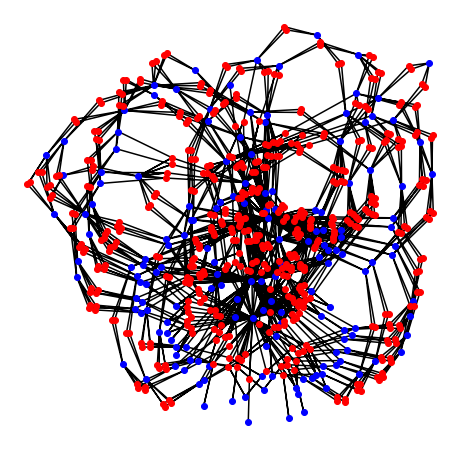

In [13]:
import matplotlib.pyplot as plt
from NorthNet.network_visualisation.layouts import generate_networkx_layout

# For visualisation, non-chemical aware editing is more easily performed
# using a networkx DiGraph
G = reaction_network.convert_to_networkx()
# Removing compounds with lots of reactions connected to them aids in creating
# a more 'open' layout so we can see some detail.
[G.remove_node(n) for n in ["C=O","O","[OH-]"]]

pos = generate_networkx_layout(G, render_engine = "sfdp")

# The layout can be generated directly from the network, too.
# pos = vis.generate_network_layout(reaction_network, render_engine = "sfdp")

reaction_node_pos = list(
                        map(
                          list, zip(
                          *[pos[r] for r in reaction_network.NetworkReactions]
                          )
                        )
                    )

compound_node_pos = list(
                        map(
                          list, zip(
                          *[pos[c] for c in reaction_network.NetworkCompounds if c in G.nodes]
                          )
                        )
                    )

fig, ax = plt.subplots(figsize = (8,8))

edges_x = []
edges_y = []
for rxn in reaction_network.NetworkReactions:
    reaction = reaction_network.NetworkReactions[rxn]

    for reactant in reaction.Reactants:
        if reactant in pos:
            edges_x.append(pos[reactant][0])
            edges_x.append(pos[rxn][0])
            edges_y.append(pos[reactant][1])
            edges_y.append(pos[rxn][1])
    edges_x.append(None)
    edges_y.append(None)
    for product in reaction.Products:
        if product in pos:
            edges_x.append(pos[product][0])
            edges_x.append(pos[rxn][0])
            edges_y.append(pos[product][1])
            edges_y.append(pos[rxn][1])
    edges_x.append(None)
    edges_y.append(None)

ax.scatter(compound_node_pos[0], compound_node_pos[1], c = "b", label = "compounds")
ax.scatter(reaction_node_pos[0], reaction_node_pos[1], c = "r", label = "reactions")
ax.plot(edges_x, edges_y, c = "k", zorder = 0)
ax.set_axis_off()
plt.show()

## Inspecting a Network

I wonder what those 'terminal'-looking compounds are? 🧐

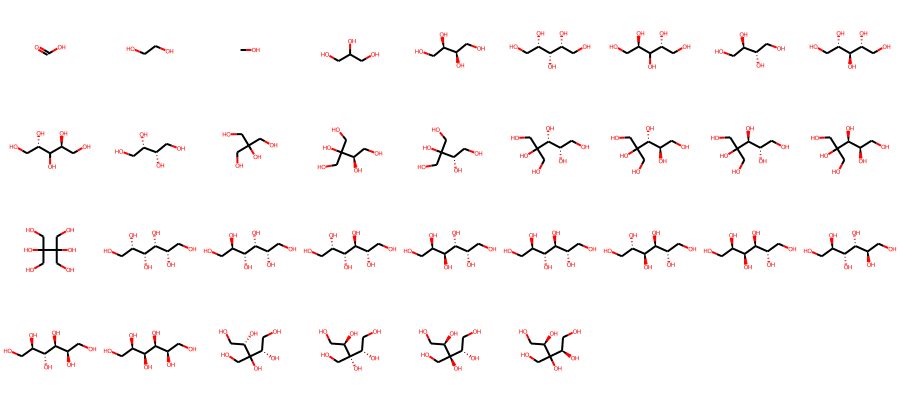

In [14]:
from rdkit.Chem import Draw

terminal_mols = []
for c in reaction_network.NetworkCompounds:
    # If there are no reactions leading out of a compound,
    # then it is a 'dead end'.
    if len(reaction_network.NetworkCompounds[c].Out) == 0:
        terminal_mols.append(reaction_network.NetworkCompounds[c].Mol)

Draw.MolsToGridImage(terminal_mols,molsPerRow=9,subImgSize=(100,100))

They are the products of Cannizzaro reactions of course!☺️